In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score

In [145]:
import xgboost
from xgboost import XGBClassifier

In [185]:
train=pd.read_csv("./Data/Training_dataset_Original.csv", low_memory=False)
test=pd.read_csv("./Data/Leaderboard_dataset.csv", low_memory=False)

In [186]:
data.shape

(105000, 51)

In [187]:
def replace_nan(data):
    data = data.replace("nan", np.nan)
    data = data.replace("missing", np.nan)
    data = data.replace("na", np.nan)
    return data

In [188]:
train = replace_nan(train)
test = replace_nan(test)

In [189]:
def fill_data(data):
    data['mvar47'] = data['mvar47'] == 'C'
    data = data.astype(dtype='float64')
    data = data.fillna(data.median())
#     data = data.fillna(data.mean())
    return data

In [190]:
train = fill_data(train)
test = fill_data(test)

In [191]:
data=pd.concat([train, test], sort=False)
# data=pd.concat([train.drop('default_ind', axis=1), test])

In [192]:
test.head()

,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,...,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,350053.0,1753.0,0.5001,0.000,0.0,0.0,206.0,19179.0,206.0,14221.0,...,1.0,0.0,100.000,20.551,0.42105,3.0,0.85661,0.0,0.0,0.0
1,350054.0,1894.0,1.9701,0.000,0.0,0.0,297.0,19820.0,19820.0,176895.0,...,3.0,0.0,100.000,63.047,0.00000,15.0,0.94391,0.0,0.0,1.0
2,350055.0,1774.0,0.1718,0.000,0.0,0.0,197.0,2563.0,877.0,8869.0,...,1.0,0.0,100.000,83.797,0.33333,3.0,0.76467,0.0,0.0,1.0
3,350056.0,1586.0,0.1123,5.299,0.0,0.0,297.0,7011.5,2503.0,14072.0,...,1.0,0.0,100.000,79.123,1.50000,0.0,0.73274,0.0,0.0,1.0
4,350057.0,1832.0,1.4442,0.000,0.0,0.0,179.0,7577.0,179.0,21059.0,...,3.0,0.0,96.052,66.665,0.00000,23.0,0.79190,0.0,0.0,0.0


In [193]:
def preparing_data(train,test):

    categorical = ["mvar16", "mvar34"]

    def replacing_categorical(X):
        x=train.groupby(X)["default_ind"].mean()
        y=train.groupby(X)["default_ind"].std()
#         data[X+str("_mean")]= data[X].apply(lambda X1: x[X1])
#         data[X+str("_std")] = data[X].apply(lambda X2: y[X2])

    for i in categorical:
        replacing_categorical(i)
   
    train_new = data.iloc[0:train.shape[0]]
    test_new = data.iloc[train.shape[0]:data.shape[0]]

    def prepare_data(df, is_train):
        # Dropping cm_key
#         df = df.drop(["application_id"], axis=1)
        # Dropping mvar1 due to uniformity
#         df  = df.drop(["mvar1"], axis=1)
        if is_train:
            return df.drop(['application_key',"default_ind", "mvar21", "mvar22", "mvar23"], axis=1), df['default_ind']
        return df.drop(['application_key',"default_ind", "mvar21", "mvar22", "mvar23"], axis=1)


    train_features, train_target = prepare_data(train_new, 1)
    test_features = prepare_data(test_new, 0)
    
    return train_features, train_target, test_features

In [194]:
train_features, train_target, test_features = preparing_data(train,test)

In [195]:
test_features.head()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,1753.0,0.5001,0.000,0.0,0.0,206.0,19179.0,206.0,14221.0,19438.0,...,1.0,0.0,100.000,20.551,0.42105,3.0,0.85661,0.0,0.0,0.0
1,1894.0,1.9701,0.000,0.0,0.0,297.0,19820.0,19820.0,176895.0,66346.0,...,3.0,0.0,100.000,63.047,0.00000,15.0,0.94391,0.0,0.0,1.0
2,1774.0,0.1718,0.000,0.0,0.0,197.0,2563.0,877.0,8869.0,3637.0,...,1.0,0.0,100.000,83.797,0.33333,3.0,0.76467,0.0,0.0,1.0
3,1586.0,0.1123,5.299,0.0,0.0,297.0,7011.5,2503.0,14072.0,0.0,...,1.0,0.0,100.000,79.123,1.50000,0.0,0.73274,0.0,0.0,1.0
4,1832.0,1.4442,0.000,0.0,0.0,179.0,7577.0,179.0,21059.0,20306.0,...,3.0,0.0,96.052,66.665,0.00000,23.0,0.79190,0.0,0.0,0.0


In [196]:
def model(train,test):
    train_features, train_target, test_features = preparing_data(train,test)
    Xtrain, Xtest, ytrain, ytest = train_test_split( train_features, train_target,
                                                    stratify=train_target, test_size=.3, random_state=100)
    
    print(train_features.head())
#     train_features = train_features.values
#     test_features = test_features.values
    xgb = XGBClassifier(n_estimators= 1000, seed=100)
    xgb.fit(train_features, train_target)
    
    print ("Training :"+str(accuracy_score( ytrain, xgb.predict(Xtrain))))
    print ("Test :"+str(accuracy_score( ytest, xgb.predict(Xtest))))
    print ("ROC_AUC :"+str(roc_auc_score( ytest, xgb.predict(Xtest))))
    print ("precision_score :"+str(precision_score( ytest, xgb.predict(Xtest))))
    print ("recall_score :"+str(recall_score( ytest, xgb.predict(Xtest))))
    print ("confusion_matrix :"+ str(confusion_matrix(ytest, xgb.predict(Xtest))))

    def myscorer(cm):
        False1 = cm[0][1]
        False2 = cm[1][0]
        return (3*False1) + (False2), (False1+False2)

    print ("myscorer :"+ str(myscorer(confusion_matrix(ytest, xgb.predict(Xtest)))))
           
    ax = xgboost.plot_importance(xgb)
    fig = ax.figure
    fig.set_size_inches(15, 15)

In [172]:
# train = train.astype(dtype='float64')
# test = test.astype(dtype='float64')

    mvar1   mvar2  mvar3  mvar4  mvar5   mvar6    mvar7   mvar8    mvar9  \
0  1696.0  1.6541  0.000    0.0    0.0     0.0   6015.0   322.0  40369.0   
1  1846.0  0.8095  0.000    0.0    0.0   102.0   7532.0  3171.0  18234.0   
2  1745.0  0.4001  0.000    0.0    0.0   297.0   2536.0  2478.0  14171.0   
3  1739.0  0.2193  0.000    0.0    0.0  1982.0  26440.0  4955.0  20316.0   
4  1787.0  0.0118  0.225    0.0    0.0  5451.0   5494.0  5494.0   7987.0   

    mvar10   ...    mvar38  mvar39   mvar40   mvar41   mvar42  mvar43  \
0  18414.0   ...       4.0     1.0   73.780  82.5470  0.08696    10.0   
1  13664.0   ...       2.0     0.0   99.129  78.8835  0.00000    13.0   
2   2536.0   ...       1.0     0.0  100.000  29.2900  0.00000     1.0   
3  37013.0   ...       2.0     0.0   96.272  78.8835  0.15385     3.0   
4   4696.0   ...       2.0     0.0  115.019  78.8835  0.00000     1.0   

    mvar44  mvar45  mvar46  mvar47  
0  0.63899     0.0     0.0     1.0  
1  0.63836     0.0     0.0    

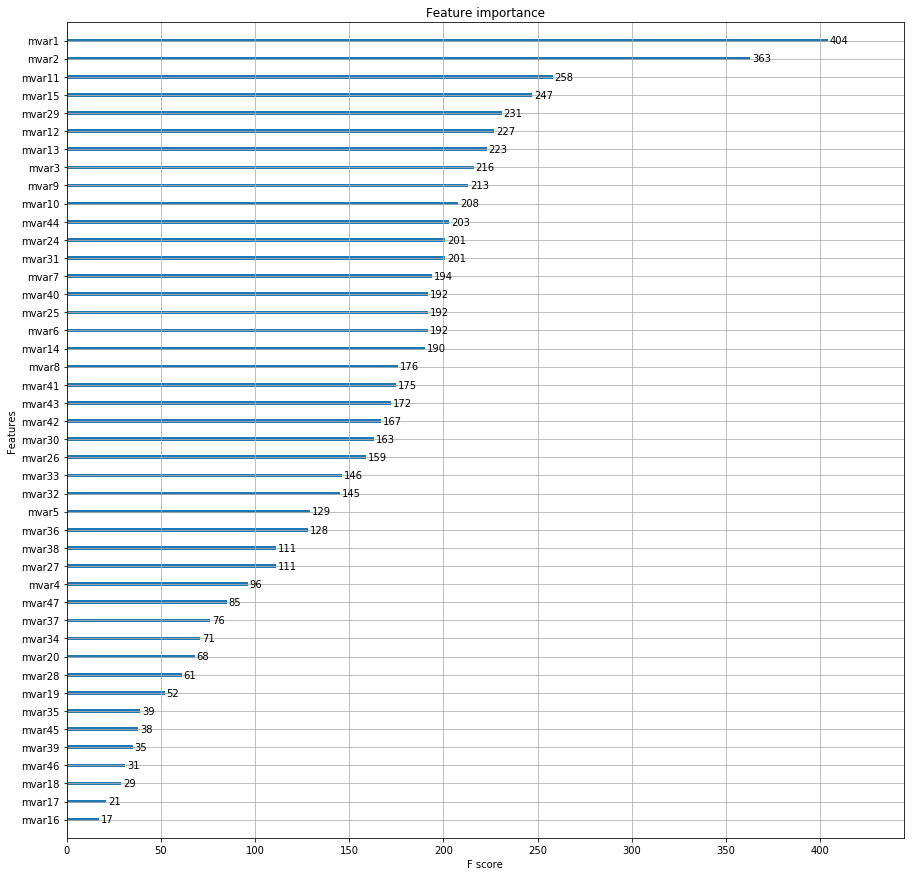

In [197]:
model(train, test)

In [198]:
train_features, train_target, test_features = preparing_data(train, test)
xgb = XGBClassifier(n_estimators= 1000, seed=100)
xgb.fit(train_features, train_target)
submission = pd.concat([test["application_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["0","1"])], axis=1)

In [200]:
# xgb.predict_proba(test_features)
test_features.shape

(25000, 44)

In [201]:
submission.head()

,application_key,0,1
0,350053.0,0.963231,0.036769
1,350054.0,0.908026,0.091975
2,350055.0,0.888974,0.111026
3,350056.0,0.347829,0.652171
4,350057.0,0.908727,0.091273


In [163]:
Y_pred=xgb1.predict(X_test)

In [164]:
xgb1.predict_proba(X_test)

array([[0.93748975, 0.06251027],
       [0.89933276, 0.10066727],
       [0.6918422 , 0.30815783],
       ...,
       [0.9848882 , 0.0151118 ],
       [0.97661865, 0.02338136],
       [0.9011196 , 0.09888041]], dtype=float32)

In [165]:
float(np.sum(Y_pred == Y_test))/float(np.sum(Y_test == Y_test))

0.8303929430633521

In [166]:
metrics.accuracy_score(Y_test, Y_pred)

0.8303929430633521

In [167]:
X_lead = pd.read_csv('./RefinedData/refined_leaderboard_data.csv', low_memory=False)

In [168]:
X_lead.head()

,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,...,mvar34,mvar36,mvar37,mvar38,mvar39,mvar42,mvar43,mvar44,mvar46,mvar47
0,350053.0,1753.0,0.5001,0.000,0.0,0.0,206.000000,19179.000000,206.000000,14221.000000,...,0.0,3.0,11.0,1.0,0.000000,0.42105,3.0,0.856610,0.000000,0.0
1,350054.0,1894.0,1.9701,0.000,0.0,0.0,297.000000,19820.000000,19820.000000,176895.000000,...,0.0,3.0,12.0,3.0,0.000000,0.00000,15.0,0.943910,0.000000,1.0
2,350055.0,1774.0,0.1718,0.000,0.0,0.0,197.000000,2563.000000,877.000000,8869.000000,...,0.0,3.0,4.0,1.0,0.000000,0.33333,3.0,0.764670,0.000000,1.0
3,350056.0,1586.0,0.1123,5.299,0.0,0.0,1624.069192,17750.368864,6753.202313,33825.554662,...,0.0,1.0,0.0,1.0,0.089912,1.50000,0.0,0.702558,0.092712,1.0
4,350057.0,1832.0,1.4442,0.000,0.0,0.0,179.000000,7577.000000,179.000000,21059.000000,...,0.0,17.0,0.0,3.0,0.000000,0.00000,23.0,0.791900,0.000000,0.0


In [169]:
Y_lead=pd.DataFrame(xgb1.predict(X_lead))

In [170]:
Y_prob = xgb1.predict_proba(X_lead)
Y_prob

array([[0.9283207 , 0.07167929],
       [0.9487862 , 0.0512138 ],
       [0.8573368 , 0.1426632 ],
       ...,
       [0.8759706 , 0.12402939],
       [0.9473692 , 0.0526308 ],
       [0.97857946, 0.02142052]], dtype=float32)

In [171]:
Y_wt = Y_prob[:,0]
Y_wt = np.abs(Y_wt - 0.5)
Y_wt

array([0.4283207 , 0.4487862 , 0.35733682, ..., 0.3759706 , 0.44736922,
       0.47857946], dtype=float32)

In [172]:
sol = pd.DataFrame()
sol['priority'] = pd.Series(Y_wt)
sol['application_key'] = X_lead['application_key'].astype(dtype='int')
sol['default_ind'] = Y_lead.astype(dtype='int')

In [173]:
sol.head()

,priority,application_key,default_ind
0,0.428321,350053,0
1,0.448786,350054,0
2,0.357337,350055,0
3,0.214823,350056,0
4,0.364394,350057,0


In [174]:
sol.sort_values(by = 'priority', ascending = False)

,priority,application_key,default_ind
18874,0.486653,368927,0
3323,0.486651,353376,0
22354,0.486649,372407,0
193,0.486643,350246,0
3708,0.486609,353761,0
14065,0.486578,364118,0
12094,0.486468,362147,0
23075,0.486466,373128,0
11125,0.486458,361178,0
22292,0.486456,372345,0


In [175]:
#sol = sol.drop('priority', axis = 1)
sol.to_csv(path_or_buf='./Submissions/Analyzing_IITGuwahati_26.csv', index = False, header=False)